# Notebook to generate plots for *"A Comparative Study of High-Order Singular Value Decomposition and Principal Component Analysis for Combustion Data Analysis"*

This notebook contains the code employed to generate the plots displayed in paper. The algorithms implemented is not optimal, but fully functional to understand the math behind the plots

In [16]:
import numpy as np
import json
import matplotlib.pyplot as plt
import tensorly as tl
from tensorly.tenalg import mode_dot, multi_mode_dot
import kagglehub
from tqdm import tqdm
import pandas as pd

## Data download and reading

In [17]:
reynolds_numbers = [8000]
paths = [f"sharmapushan/hydrogen-jet-{re}" for re in reynolds_numbers]
data_paths = [kagglehub.dataset_download(name) for name in paths]
#this part of the code is taken from multiple RE analysis
data_path = data_paths[0]
with open(data_paths[0] + '/info.json') as f:
    metadata = json.load(f)


In [18]:
# variable definition
subsample_x, subsample_y = 5, 5
Nx, Ny = metadata['global']['Nxyz']
n_snapshots = metadata['global']['snapshots'] - 1
Nx_sub = Nx // subsample_x
Ny_sub = Ny // subsample_y

component_names = ['YH', 'YH2', 'YO', 'YO2', 'YOH', 'YH2O', 'YHO2', 'YH2O2']
species_names = [cname[1:] for cname in component_names]
n_species = len(component_names)
molar_masses = {'YH': 1.0, 'YH2': 2.0, 'YO': 8.0, 'YO2': 16.0, 'YOH': 9.0, 'YH2O': 10.0, 'YHO2': 17.0, 'YH2O2': 18.0}
file_key_map = file_key_map = {'YH': 'YH filename', 'YH2': 'YH2 filename', 'YO': 'YO filename', 'YO2': 'YO2 filename',
                                'YOH': 'YOH filename', 'YH2O': 'YH2O filename', 'YHO2': 'YHO2 filename', 'YH2O2': 'YH2O2 filename'
}

Lx, Ly = 12.5, 15.6# domain size in D units

print(f"Grid: {Nx}x{Ny}, Subsampled: {Nx_sub}x{Ny_sub}")

Grid: 1600x2000, Subsampled: 320x400


In [19]:
# Data loading
# Since I work with only one tensor, I don't need dicts
tensor = np.zeros((Ny_sub, Nx_sub, n_species, n_snapshots))

for t_idx in tqdm(range(n_snapshots)):
    for new_idx, (comp_name, orig_idx) in enumerate(zip(component_names, range(n_species))):
        filename_key = file_key_map[comp_name]
        filename = metadata['local'][t_idx][filename_key]
        data = np.fromfile(f"{data_path}/{filename}", dtype='<f4').reshape(Ny, Nx)
        molar_data = data / molar_masses[comp_name]
        tensor[:, :, new_idx, t_idx] = molar_data[::subsample_x, ::subsample_y]
    
print(tensor.shape)
print("Data loading complete!")


100%|██████████| 200/200 [00:08<00:00, 24.38it/s]

(400, 320, 8, 200)
Data loading complete!


In [20]:
def scale_and_center_tensor(tensor, component_names = component_names, log_scale=True, 
                             std_scale=True, epsilon=1e-12):
    tensor_scaled = tensor.copy()  
    for c_idx, comp_name in enumerate(component_names):
        component_data = tensor_scaled[:, :, c_idx, :].copy()            
        if log_scale:
            component_data = np.log10(np.maximum(component_data, epsilon))
        if std_scale:
            mean_val = component_data.mean()
            std_val = component_data.std()                
            if std_val < epsilon:
                std_val = epsilon  # Prevent divide-by-zero
            component_data = (component_data - mean_val) / std_val
        tensor_scaled[:, :, c_idx, :] = component_data
    return tensor_scaled

tensor_scaled = scale_and_center_tensor(tensor)

### Visualization of tensor and tensor scaled

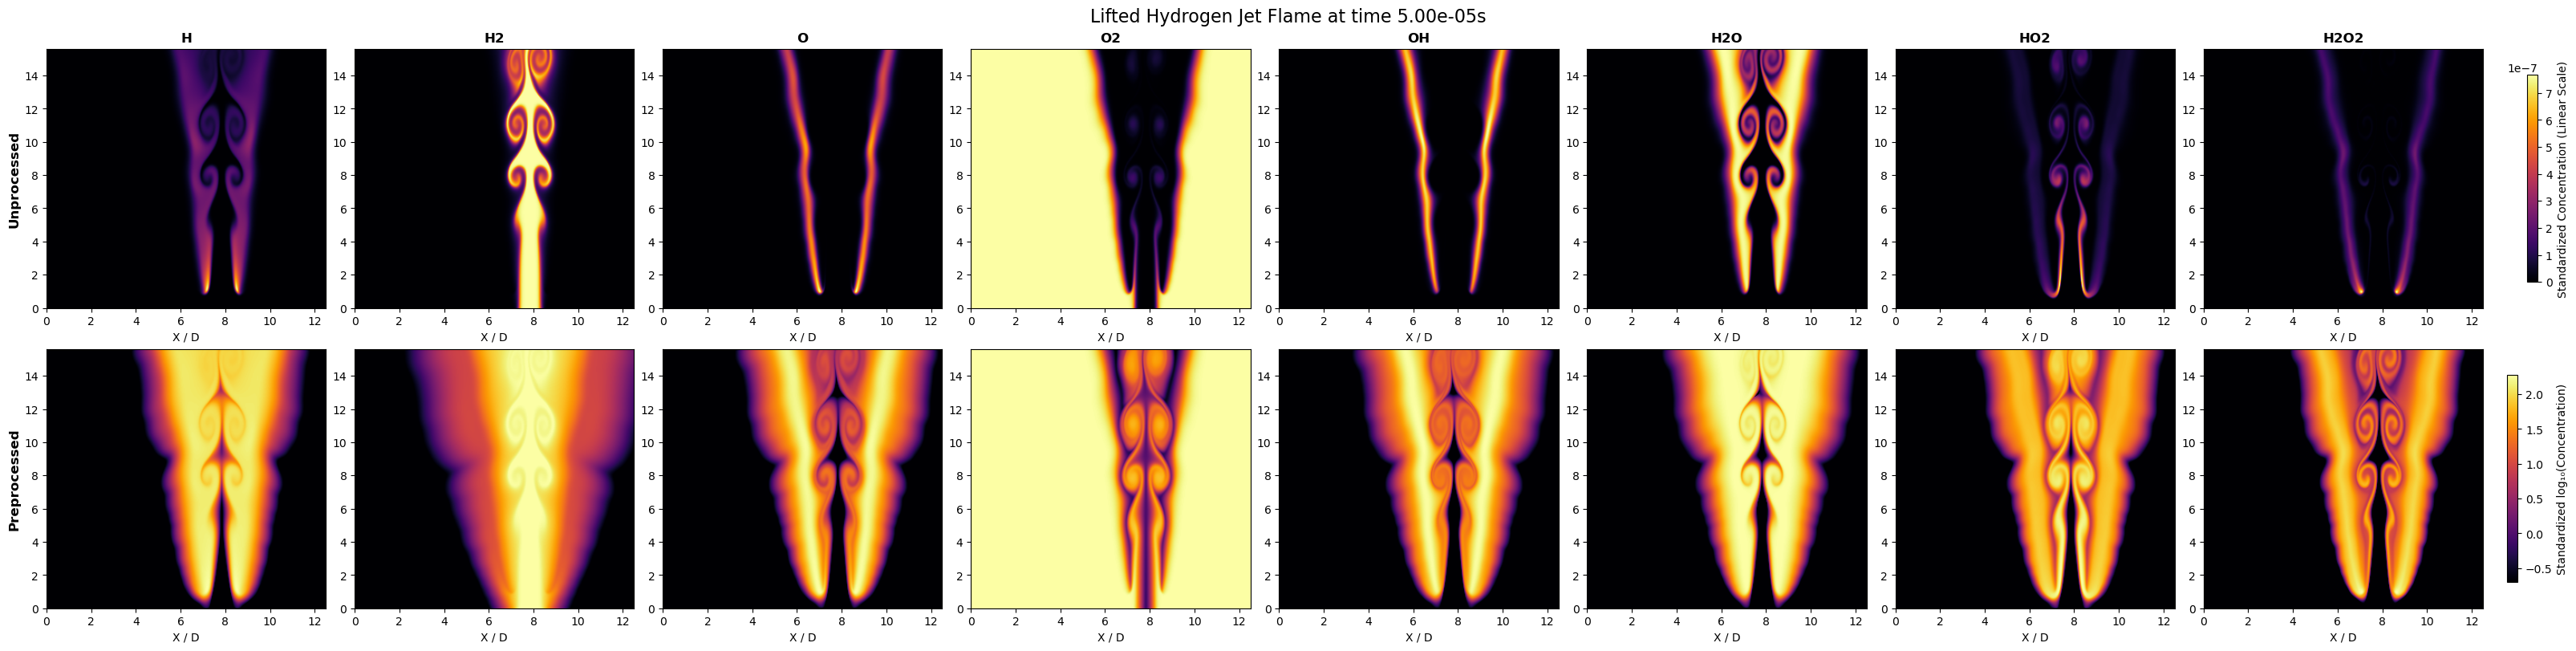

In [21]:
x = np.linspace(0, Lx, Nx_sub)
y = np.linspace(0, Ly, Ny_sub)
t = 10
time_conversion_factor = 5e-06

fig, axes = plt.subplots(2, 8, figsize=(32, 8), constrained_layout=True)
fig.suptitle(f"Lifted Hydrogen Jet Flame at time {t * time_conversion_factor:.2e}s", fontsize=16)

tensor_plot = tensor
tensor_plot_log = tensor_scaled


for idx in range(8):
    im = axes[0, idx].imshow(
        tensor_plot[:, :, idx, t],
        cmap='inferno',
        origin='lower',
        extent=[0, Lx, 0, Ly],
        aspect='auto'
    )
    #axes[0, idx].set_title(f"{component_names[idx][1:]}")
    axes[0, idx].set_xlabel("X / D")
    if idx == 0:
        axes[0, idx].set_ylabel("Y / D")

cbar1 = fig.colorbar(im, ax=axes[0, :], orientation='vertical', 
                      label="Standardized Concentration (Linear Scale)", 
                      pad=0.01, shrink=0.8)

for idx in range(8):
    im_log = axes[1, idx].imshow(
        tensor_plot_log[:, :, idx, t],
        cmap='inferno',
        origin='lower',
        extent=[0, Lx, 0, Ly],
        aspect='auto'
    )
    #axes[1, idx].set_title(f"{component_names[idx][1:]}")
    axes[1, idx].set_xlabel("X / D")
    if idx == 0:
        axes[1, idx].set_ylabel("Y / D")
cbar2 = fig.colorbar(im_log, ax=axes[1, :], orientation='vertical', 
                      label="Standardized log₁₀(Concentration)", 
                      pad=0.01, shrink=0.8)
cols = [component_name[1:] for component_name in component_names]
rows = ["Unprocessed", "Preprocessed"]
for ax, col in zip(axes[0], cols):
    ax.set_title(col,  size='large', fontweight = "bold")

for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=90, size='large', fontweight = "bold")

plt.savefig(fname='README_PLOTS/data_comparison.png')

plt.show()

## Low-Cost HOSVD Variants

In this section, we implement and compare three low-cost variants of HOSVD:
1. **Randomized HOSVD**: Uses randomized SVD for faster computation
2. **Sequentially Truncated HOSVD (ST-HOSVD)**: Truncates after each mode to reduce computational cost
3. **Subsampled HOSVD**: Uses fiber sampling to approximate the decomposition

In [43]:
import time

def randomized_svd(matrix, n_components, n_oversamples=1, n_iter=1):
    """
    Randomized SVD using power iteration method.
    
    Parameters:
    -----------
    matrix : ndarray
        Input matrix to decompose
    n_components : int
        Number of components to keep
    n_oversamples : int
        Additional samples for accuracy
    n_iter : int
        Number of power iterations
        
    Returns:
    --------
    U, s, Vt : ndarrays
        Truncated SVD components
    """
    m, n = matrix.shape
    n_random = min(n_components + n_oversamples, min(m, n))
    
    Q = np.random.randn(n, n_random)
    
    for _ in range(n_iter):
        Q = matrix @ Q
        Q, _ = np.linalg.qr(Q)
        Q = matrix.T @ Q
        Q, _ = np.linalg.qr(Q)
    
    Q = matrix @ Q
    Q, _ = np.linalg.qr(Q)
    
    B = Q.T @ matrix
    U_tilde, s, Vt = np.linalg.svd(B, full_matrices=False)
    U = Q @ U_tilde
    
    return U[:, :n_components], s[:n_components], Vt[:n_components, :]

print("Randomized SVD function defined")

Randomized SVD function defined


### 1. Randomized HOSVD

Uses randomized SVD for each mode unfolding, which is faster for large matrices.

In [44]:
def randomized_hosvd(tensor, ranks):
    """
    Randomized HOSVD implementation.
    
    Parameters:
    -----------
    tensor : ndarray
        Input tensor
    ranks : list
        Number of components to keep for each mode
        
    Returns:
    --------
    factors : list
        List of factor matrices for each mode
    core : ndarray
        Core tensor
    """
    n_modes = len(tensor.shape)
    factors = []
    
    start_time = time.time()
    
    for mode in range(n_modes):
        unfolded = tl.unfold(tensor, mode)
        n_components = min(ranks[mode], min(unfolded.shape))
        U, _, _ = randomized_svd(unfolded, n_components)
        factors.append(U)
    
    # Compute core tensor
    core = multi_mode_dot(tensor, [U.T for U in factors], modes=list(range(n_modes)))
    
    elapsed_time = time.time() - start_time
    
    return factors, core, elapsed_time

# Set ranks for each mode (keeping most of the information)
ranks = [20, 15, 8, 10]  # [y, x, chem, time]

factors_rand, core_rand, time_rand = randomized_hosvd(tensor_scaled, ranks)
print(f"Randomized HOSVD completed in {time_rand:.4f} seconds")
print(f"Core shape: {core_rand.shape}")

Randomized HOSVD completed in 24.6365 seconds
Core shape: (20, 15, 8, 10)


### 2. Sequentially Truncated HOSVD (ST-HOSVD)

Truncates the tensor after processing each mode to reduce memory and computation for subsequent modes.

In [34]:
def sequentially_truncated_hosvd(tensor, ranks):
    """
    Sequentially Truncated HOSVD (ST-HOSVD) implementation.
    Truncates the tensor after processing each mode.
    
    Parameters:
    -----------
    tensor : ndarray
        Input tensor
    ranks : list
        Number of components to keep for each mode
    
    Returns:
    --------
    factors : list
        List of factor matrices for each mode
    core : ndarray
        Core tensor
    elapsed_time : float
        Time taken for computation
    """
    n_modes = len(tensor.shape)
    factors = []
    current_tensor = tensor.copy()
    start_time = time.time()
    
    for mode in tqdm(range(n_modes), desc="ST-HOSVD"):
        unfolded = tl.unfold(current_tensor, mode)
        
        U, s, Vt = np.linalg.svd(unfolded, full_matrices=False)
        n_components = min(ranks[mode], len(s))
        U_truncated = U[:, :n_components]
        
        factors.append(U_truncated)
        
        current_tensor = tl.tenalg.mode_dot(current_tensor, U_truncated.T, mode)
    
    # current_tensor is now the core tensor
    core = current_tensor
    
    elapsed_time = time.time() - start_time
    return factors, core, elapsed_time

factors_st, core_st, time_st = sequentially_truncated_hosvd(tensor_scaled, ranks)
print(f"Sequentially Truncated HOSVD completed in {time_st:.4f} seconds")
print(f"Core shape: {core_st.shape}")

ST-HOSVD: 100%|██████████| 4/4 [00:17<00:00,  4.46s/it]

Sequentially Truncated HOSVD completed in 17.8305 seconds
Core shape: (20, 15, 8, 10)


### 3. Subsampled HOSVD

Uses fiber sampling to approximate the mode matrices, reducing computational cost.

In [35]:
def subsampled_hosvd(tensor, ranks, sampling_ratio=0.3):
    """
    Subsampled HOSVD implementation using fiber sampling.
    
    Parameters:
    -----------
    tensor : ndarray
        Input tensor
    ranks : list
        Number of components to keep for each mode
    sampling_ratio : float
        Fraction of fibers to sample (0 < sampling_ratio <= 1)
        
    Returns:
    --------
    factors : list
        List of factor matrices for each mode
    core : ndarray
        Core tensor
    """
    n_modes = len(tensor.shape)
    factors = []
    
    start_time = time.time()
    
    for mode in range(n_modes):
        unfolded = tl.unfold(tensor, mode)
        m, n = unfolded.shape
        
        n_samples = max(int(n * sampling_ratio), ranks[mode] * 2)
        n_samples = min(n_samples, n)
        
        sample_indices = np.random.choice(n, size=n_samples, replace=False)
        sampled_matrix = unfolded[:, sample_indices]
        
        U, _, _ = np.linalg.svd(sampled_matrix, full_matrices=False)
        n_components = min(ranks[mode], min(m, n_samples))
        U_truncated = U[:, :n_components]
        
        factors.append(U_truncated)
    
    core = multi_mode_dot(tensor, [U.T for U in factors], modes=list(range(n_modes)))
    
    elapsed_time = time.time() - start_time
    
    return factors, core, elapsed_time

factors_sub, core_sub, time_sub = subsampled_hosvd(tensor_scaled, ranks, sampling_ratio=0.3)
print(f"Subsampled HOSVD completed in {time_sub:.4f} seconds")
print(f"Core shape: {core_sub.shape}")

Subsampled HOSVD completed in 21.9031 seconds
Core shape: (20, 15, 8, 10)


## Comparison: Reconstruction Error and Computation Time

In [36]:
# Compute standard HOSVD with timing for comparison
def standard_hosvd_timed(tensor, ranks):
    """
    Standard HOSVD with timing and truncation to specified ranks.
    """
    start_time = time.time()
    
    factors = []
    for mode in range(len(tensor.shape)):
        U, _, _ = np.linalg.svd(tl.unfold(tensor, mode), full_matrices=False)
        n_components = min(ranks[mode], U.shape[1])
        factors.append(U)
    
    core = multi_mode_dot(tensor, [U.T for U in factors], modes=list(range(len(tensor.shape))))
    
    elapsed_time = time.time() - start_time
    
    return factors, core, elapsed_time

print("Computing standard HOSVD with truncation for comparison...")
factors_std, core_std, time_std = standard_hosvd_timed(tensor_scaled, ranks)
print(f"Standard HOSVD completed in {time_std:.4f} seconds")
print(f"Core shape: {core_std.shape}")

Computing standard HOSVD with truncation for comparison...
Standard HOSVD completed in 69.3871 seconds
Core shape: (400, 320, 8, 200)


In [45]:
def compute_reconstruction_error(tensor_original, factors, core):
    """
    Compute relative reconstruction error.
    
    Parameters:
    -----------
    tensor_original : ndarray
        Original tensor
    factors : list
        List of factor matrices
    core : ndarray
        Core tensor
        
    Returns:
    --------
    error : float
        Relative reconstruction error (Frobenius norm)
    """
    tensor_reconstructed = multi_mode_dot(core, factors, modes=list(range(len(factors))))
    
    error = np.linalg.norm(tensor_original - tensor_reconstructed) / np.linalg.norm(tensor_original)
    
    return error

print("\nComputing reconstruction errors...")
error_std = compute_reconstruction_error(tensor_scaled, factors_std, core_std)
error_rand = compute_reconstruction_error(tensor_scaled, factors_rand, core_rand)
error_st = compute_reconstruction_error(tensor_scaled, factors_st, core_st)
error_sub = compute_reconstruction_error(tensor_scaled, factors_sub, core_sub)

print(f"\nReconstruction Errors (relative Frobenius norm):")
print(f"  Standard HOSVD:              {error_std:.6e}")
print(f"  Randomized HOSVD:            {error_rand:.6e}")
print(f"  Sequentially Truncated HOSVD: {error_st:.6e}")
print(f"  Subsampled HOSVD:            {error_sub:.6e}")

print(f"\nComputation Times:")
print(f"  Standard HOSVD:              {time_std:.4f} seconds")
print(f"  Randomized HOSVD:            {time_rand:.4f} seconds")
print(f"  Sequentially Truncated HOSVD: {time_st:.4f} seconds")
print(f"  Subsampled HOSVD:            {time_sub:.4f} seconds")


Computing reconstruction errors...

Reconstruction Errors (relative Frobenius norm):
  Standard HOSVD:              1.988240e-15
  Randomized HOSVD:            9.812585e-02
  Sequentially Truncated HOSVD: 9.368570e-02
  Subsampled HOSVD:            9.383013e-02

Computation Times:
  Standard HOSVD:              69.3871 seconds
  Randomized HOSVD:            24.6365 seconds
  Sequentially Truncated HOSVD: 17.8305 seconds
  Subsampled HOSVD:            21.9031 seconds


### Visualization of Results

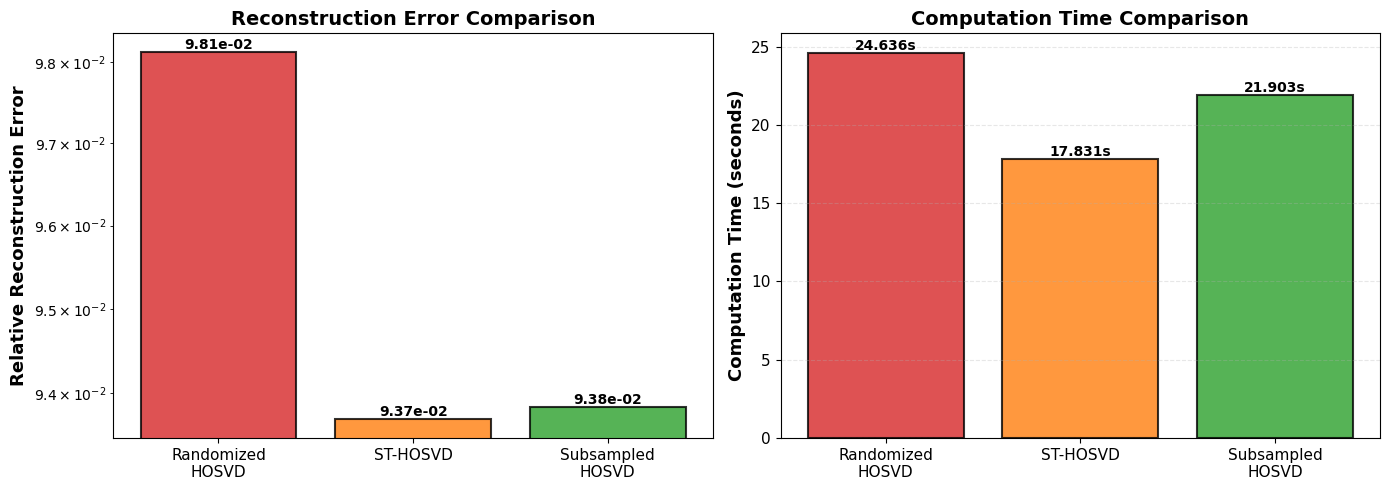


Comparison plot saved to 'README_PLOTS/hosvd_comparison.png'


In [46]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

methods_plot = ['Randomized\nHOSVD', 'ST-HOSVD', 'Subsampled\nHOSVD']
errors_plot = [error_rand, error_st, error_sub]
times_plot = [time_rand, time_st, time_sub]
colors = ['#D62728', '#FF7F0E', '#2CA02C']

ax1 = axes[0]
bars1 = ax1.bar(methods_plot, errors_plot, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Relative Reconstruction Error', fontsize=13, fontweight='bold')
ax1.set_title('Reconstruction Error Comparison', fontsize=14, fontweight='bold')
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3, linestyle='--', axis='y')
ax1.tick_params(axis='x', rotation=0, labelsize=11)
ax1.tick_params(axis='y', labelsize=11)

for bar, error in zip(bars1, errors_plot):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{error:.2e}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

ax2 = axes[1]
bars2 = ax2.bar(methods_plot, times_plot, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Computation Time (seconds)', fontsize=13, fontweight='bold')
ax2.set_title('Computation Time Comparison', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, linestyle='--', axis='y')
ax2.tick_params(axis='x', rotation=0, labelsize=11)
ax2.tick_params(axis='y', labelsize=11)

for bar, time_val in zip(bars2, times_plot):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{time_val:.3f}s',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('README_PLOTS/hosvd_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nComparison plot saved to 'README_PLOTS/hosvd_comparison.png'")

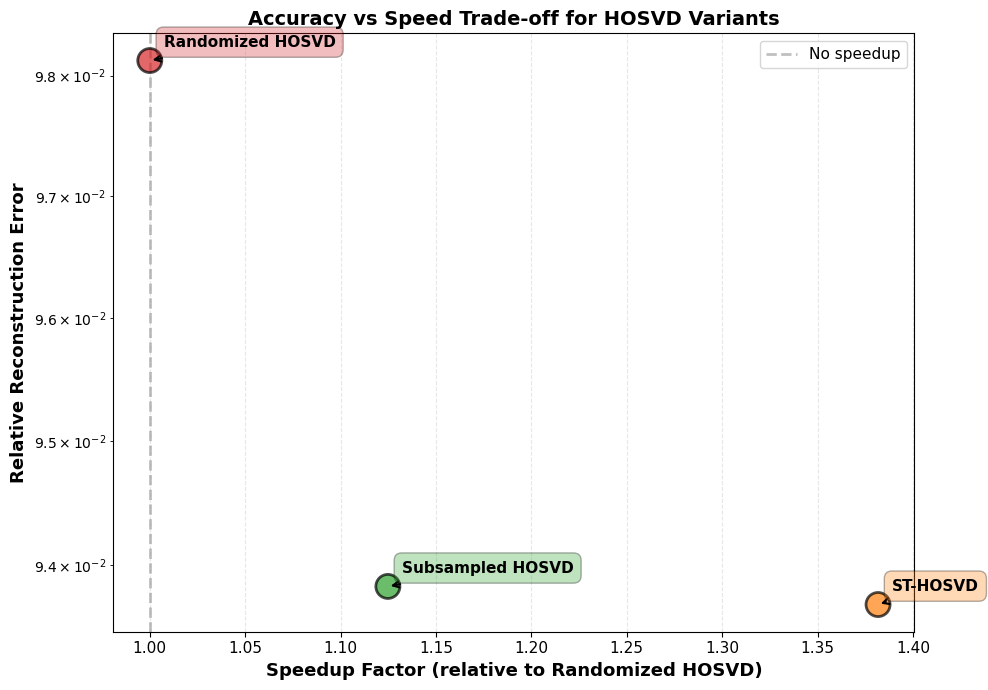


Trade-off plot saved to 'README_PLOTS/hosvd_tradeoff.png'


In [49]:
fig, ax = plt.subplots(figsize=(10, 7))

speedups_plot = [time_rand / t for t in times_plot]

scatter = ax.scatter(speedups_plot, errors_plot, s=300, c=colors, alpha=0.7, 
                     edgecolors='black', linewidth=2, zorder=3)

for i, method in enumerate(methods_plot):
    ax.annotate(method.replace('\n', ' '), 
                (speedups_plot[i], errors_plot[i]),
                xytext=(10, 10), textcoords='offset points',
                fontsize=11, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor=colors[i], alpha=0.3),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', 
                               lw=1.5, color='black'))

ax.set_xlabel('Speedup Factor (relative to Randomized HOSVD)', fontsize=13, fontweight='bold')
ax.set_ylabel('Relative Reconstruction Error', fontsize=13, fontweight='bold')
ax.set_title('Accuracy vs Speed Trade-off for HOSVD Variants', fontsize=14, fontweight='bold')
ax.set_yscale('log')
ax.grid(True, alpha=0.3, linestyle='--')
ax.tick_params(axis='both', labelsize=11)

ax.axvline(x=1, color='gray', linestyle='--', linewidth=2, alpha=0.5, label='No speedup')
ax.legend(fontsize=11)

plt.tight_layout()
plt.savefig('README_PLOTS/hosvd_tradeoff.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nTrade-off plot saved to 'README_PLOTS/hosvd_tradeoff.png'")

In [51]:
methods_table = ['Standard HOSVD', 'Randomized HOSVD', 'ST-HOSVD', 'Subsampled HOSVD']
errors_table = [error_std, error_rand, error_st, error_sub]
times_table = [time_std, time_rand, time_st, time_sub]
speedups_table = [time_std / t for t in times_table]

summary_data = {
    'Method': methods_table,
    'Computation Time (s)': times_table,
    'Speedup Factor': speedups_table,
    'Reconstruction Error': errors_table,
    'Error Ratio': [e / error_std if error_std > 0 else float('inf') for e in errors_table]
}

df_summary = pd.DataFrame(summary_data)
print("\n" + "="*80)
print("SUMMARY TABLE: HOSVD Variants Comparison (vs Standard HOSVD Baseline)")
print("="*80)
print(df_summary.to_string(index=False))
print("="*80)
print(f"\nTensor shape: {tensor_scaled.shape}")
print(f"Truncation ranks: {ranks}")
print(f"Total tensor elements: {np.prod(tensor_scaled.shape):,}")
print(f"Compressed core elements (truncated): {np.prod(core_rand.shape):,}")
print(f"Compression ratio: {np.prod(tensor_scaled.shape) / np.prod(core_rand.shape):.2f}x")


SUMMARY TABLE: HOSVD Variants Comparison (vs Standard HOSVD Baseline)
          Method  Computation Time (s)  Speedup Factor  Reconstruction Error  Error Ratio
  Standard HOSVD             69.387105        1.000000          1.988240e-15 1.000000e+00
Randomized HOSVD             24.636484        2.816437          9.812585e-02 4.935312e+13
        ST-HOSVD             17.830520        3.891480          9.368570e-02 4.711991e+13
Subsampled HOSVD             21.903104        3.167912          9.383013e-02 4.719255e+13

Tensor shape: (400, 320, 8, 200)
Truncation ranks: [20, 15, 8, 10]
Total tensor elements: 204,800,000
Compressed core elements (truncated): 24,000
Compression ratio: 8533.33x
